In [5]:
'''Import Package'''
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as sp
import scipy.optimize as spopt
from matplotlib.ticker import MaxNLocator
import emcee
import batman 
import time as t
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner
from matplotlib import gridspec
import os
from astropy.table import Table, Column
#import triangle
%matplotlib inline

# Definition of Astrophysical Model (Phase Curve)
- phase variation : 1st order sinusoidal
- transit model from BATMAN (Kreidberg 2015)
- eclipse model from BATMAN (Kreidberg 2015)
- planet flux: eclipse + phase variation (defined such that fp is the crude eclipse depth e.g. flux during superior conjunction)
- ideal lightcurve: transit + planet flux 

In [6]:
def phase_variation2(time, t_sec, per, A, B, C, D):
    # in this model, we want A+B < 1/sqrt(2) = 0.707
    #t = time - t0 + per/2
    t = time - t_sec
    w = 2*np.pi/per
    phase = 1 + A*(np.cos(w*t)-1) + (B*np.sin(w*t)) + C*(np.cos(2*w*t)-1) + (D*np.sin(2*w*t))
    return phase

def transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_secondary = m.get_t_secondary(params)
    return flux, t_secondary

def eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    #params.t_secondary = params.t0+(params.per/2.0)
    
    m = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def fplanet_model2(time, A, B, C, D, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    phase = phase_variation2(time, t_sec, per, A, B, C, D)
    eclip = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    flux = phase*(eclip - 1)
    return flux

def ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D):
    # retransformation
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.arctan(esinw/ecosw)
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    # create transit first and use orbital paramater to get time of superior conjunction
    transit, t_sec = transit_model(time, t0, 1.7429964, rp, a, inc, ecc, w, u1, u2)
    # create light curve of the planet
    fplanet = fplanet_model2(time, A, B, C, D, t0, 1.7429964, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    # add both light curves
    f_total = transit + fplanet
    return f_total

In [7]:
'''Check whether phase variation is unphysical'''
'''def check_phase(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B):
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.arctan(esinw/ecosw)
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    params = batman.TransitParams()                      #object to store transit parameters
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = 1.7429964                               #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_sec = m.get_t_secondary(params)
    
    phase = phase_variation2(time, t_sec, per, A, B)
    check = any(phase < 0.0)
    return check'''

phi = np.linspace(-np.pi, np.pi, 2000)

def check_phase(F0, C1, D1, C2, D2):
    A0 = F0/2
    A1 = 2*C1/np.pi
    B1 = -2*D1/np.pi
    A2 = 3*C2/2
    B2 = -3*D2/2
    brit = A0 + A1*np.cos(phi) + B1*np.sin(phi) + A2*np.cos(2*phi) + B2*np.sin(2*phi)
    check = any(brit < 0.0)
    return check

In [8]:
def detec_model(P1, P2, P3, P4, P5, P6, P7, P8, P9, c1, c2, c3, c4, c5, c6, c7 ,c8, c9):
    det = c1*P1 + c2*P2 +c3*P3 + c4*P4 + c5*P5 + c6*P6 + c7*P7 + c8*P8 +c9*P9
    return det

def signal(time, P1, P2, P3, P4, P5, P6, P7, P8, P9, 
           c1, c2, c3, c4, c5, c6, c7 ,c8, c9, 
           t0, rp, a, inc, ecowsw, esiw, q1, q2, fp, A, B, C, D):
    lightcurve = ideal_lightcurve2(time, t0, rp, a, inc, ecowsw, esiw, q1, q2, fp, A, B, C, D)
    det_model = detec_model(P1, P2, P3, P4, P5, P6, P7, P8, P9, c1, c2, c3, c4, c5, c6, c7 ,c8, c9)
    signal = det_model*lightcurve
    return signal

In [9]:
'''Load Data'''
def get_data(folderdata):
    path = folderdata + '/ch2_datacube_binned_AORs579.dat'
    P    = np.loadtxt(path, usecols=(0,1,2,3,4,5,6,7,8), skiprows=1)
    P_std= np.loadtxt(path, usecols=(9,10,11,12,13,14,15,16,17), skiprows=1)
    time = np.loadtxt(path, usecols=[18], skiprows=1)
    P    = P/np.median(P.sum(axis=1))
    P_std= P_std/np.median(P.sum(axis=1))
    return P, P_std, time

(0.10480896990740973, 2.0372786458333323)

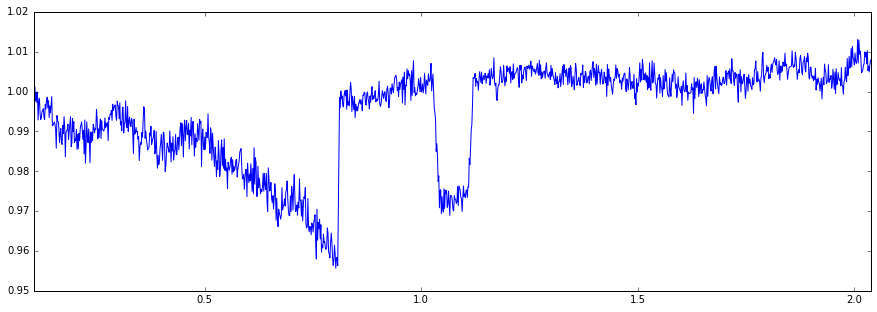

In [10]:
'''Load data'''
foldername = 'RunPLD3'
P, P_std_real, time = get_data(foldername)

start = np.min(time)

time = time-start

'''Sort array chronologically'''
index    = np.argsort(time)
time     = time[index]
P        = P[index]

ind  = np.where(time>np.min(time)+2.5/24.0)
time = time[ind]
P    = P[ind]

plt.figure(figsize = (15,5))
plt.plot(time, np.sum(P, axis = 1), '-')
plt.xlim([np.min(time), np.max(time)])

In [24]:
'''Load Best fit from lower order'''

Result_MCMC = np.load('Run4/ResultMCMC_Poly3_var2_Params.npy')

'''Initialize parameters'''

# Transit Parameters from Gillon 2010 (10 params)
t0   = Result_MCMC['t0'][0,0]       # initially in hrs
per  = 1.7429964                      # initially in days
rp   = Result_MCMC['rp'][0,0]         # initially in jupiter radius
a    = Result_MCMC['a'][0,0]          # initially in AU
inc  = Result_MCMC['inc'][0,0]
ecosw= Result_MCMC['ecosw'][0,0]      # dimensionless [0,1]                   
esinw= Result_MCMC['esinw'][0,0]
q1   = Result_MCMC['q1'][0,0]
q2   = Result_MCMC['q2'][0,0]
fp   = Result_MCMC['fp'][0,0]

# Phase Variation Parameters (2 params)
A    = Result_MCMC['A'][0,0]
B    = Result_MCMC['B'][0,0]
C    = Result_MCMC['C'][0,0]
D    = Result_MCMC['D'][0,0]

# Uncertainty
sigF = Result_MCMC['sigF'][0,0]

# Detector
c1 = 0.810855349885089
c2 = 0.660669872590439
c3 = 0.147040352224173
c4 = 1.037292564094022
c5 = 1.243063568040861
c6 = 0.657960686072725
c7 = 0.340726421434797
c8 = 1.077156478208932
c9 = 0.794302818436703

# params only 
#p0 = np.array([t0, per, rp, a, inc, ecc, w, u1, u2, fp,a1, a2, t1, t2, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
p0 = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, c1, c2, c3, c4, c5, c6, c7, c8, c9, sigF])

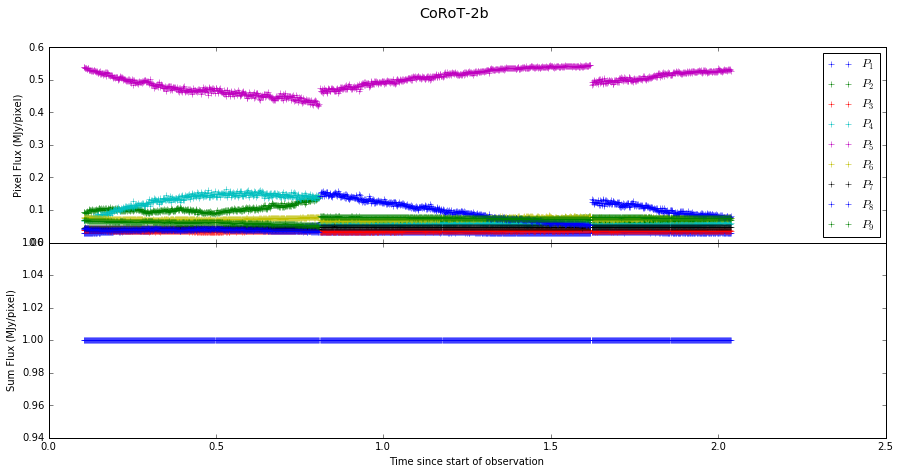

In [25]:
'''Get Frame-Normalized Flux'''
Pnorm = P/P.sum(axis=1)[:,None]

fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize=(15,7))
fig.suptitle("CoRoT-2b", fontsize="x-large")
axes[0].plot(time, Pnorm[:,0], '+', label = '$P_1$')
axes[0].plot(time, Pnorm[:,1], '+', label = '$P_2$')
axes[0].plot(time, Pnorm[:,2], '+', label = '$P_3$')
axes[0].plot(time, Pnorm[:,3], '+', label = '$P_4$')
axes[0].plot(time, Pnorm[:,4], '+', label = '$P_5$')
axes[0].plot(time, Pnorm[:,5], '+', label = '$P_6$')
axes[0].plot(time, Pnorm[:,6], '+', label = '$P_7$')
axes[0].plot(time, Pnorm[:,7], '+', label = '$P_8$')
axes[0].plot(time, Pnorm[:,8], '+', label = '$P_9$')
axes[0].set_ylabel("Pixel Flux (MJy/pixel)")
axes[0].legend()
axes[1].set_ylabel('Sum Flux (MJy/pixel)')
axes[1].plot(time, np.sum(Pnorm, axis = 1), '+')
axes[1].set_xlabel("Time since start of observation")
fig.subplots_adjust(hspace=0)

In [26]:
P1 = Pnorm[:,0]
P2 = Pnorm[:,1]
P3 = Pnorm[:,2]
P4 = Pnorm[:,3]
P5 = Pnorm[:,4]
P6 = Pnorm[:,5]
P7 = Pnorm[:,6]
P8 = Pnorm[:,7]
P9 = Pnorm[:,8]

flux = np.sum(P, axis = 1)

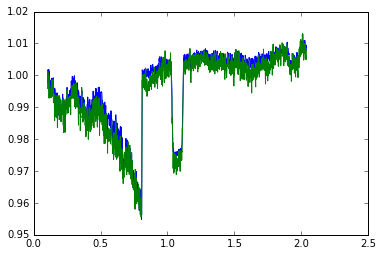

In [27]:
guess = signal(time, Pnorm[:,0], Pnorm[:,1], Pnorm[:,2], Pnorm[:,3], Pnorm[:,4], 
               Pnorm[:,5], Pnorm[:,6], Pnorm[:,7], Pnorm[:,8],
               c1, c2, c3, c4, c5, c6, c7, c8, c9, 
               t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D)


plt.figure()
plt.plot(time, guess)
plt.plot(time, flux)

In [28]:
'''''Optimization to guess the c_s'''
'''lightcurve_guess = ideal_lightcurve(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, A, B)
residual_guess   = P.sum(axis=1) - lightcurve_guess +1'''

'''Fit the residual'''
'''global Pfit 
Pfit = np.copy(Pnorm)

def P_coeff(time, c1, c2, c3, c4, c5, c6, c7, c8, c9):
    global Pfit
    func = c1*Pfit[:,0]+c2*Pfit[:,1]+c3*Pfit[:,2]+c4*Pfit[:,3]+c5*Pfit[:,4]+c6*Pfit[:,5]+c7*Pfit[:,6]+c8*Pfit[:,7]+c9*Pfit[:,8]
    return func

pinit = [1,1,1,1,1,1,1,1,1]
ub = [10,10,10,10,10,10,10,10,10]
lb = [-10,-10,-10,-10,-10,-10,-10,-10,-10]
popt, pcov = spopt.curve_fit(P_coeff, time, residual_guess, p0=pinit, bounds=(lb,ub))
c1, c2, c3, c4, c5, c6, c7, c8, c9 = popt

# update P0
p0 = np.array([1,1,1,1,1,1,1,1,1, t0, per, rp, a, inc, ecc, w, u1, u2, fp, A, B, g1, g2])
#p0 = np.array([c1, c2, c3, c4, c5, c6, c7, c8, c9, t0, per, rp, a, inc, ecc, w, u1, u2, fp, A, B, g1, g2, g3])

residual_fit = P_coeff(time, c1, c2, c3, c4, c5, c6, c7, c8, c9)
'''
'''Plot the residuals'''
'''plt.figure(figsize = (15,6))
plt.title('Residuals')
plt.plot(time, residual_guess, '+', label = 'Flux - Gillon 2010 lightcurve')
plt.plot(time, residual_fit, '+', label = '')
plt.xlim([np.min(time), np.max(time)])'''''
print('.')

.


In [29]:
'''Example'''
'''initial_guess = signal(time, Pnorm[:,0], Pnorm[:,1], Pnorm[:,2], Pnorm[:,3], 
                       Pnorm[:,4] ,Pnorm[:,5], Pnorm[:,6], Pnorm[:,7], Pnorm[:,8],
                       c1, c2, c3, c4, c5, c6, c7, c8, c9,
                       t0, per, rp, a, inc, ecc, w, u1, u2, fp, A, B, 
                       g1, g2)

fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (15,8))
axes[0].plot(time, P.sum(axis=1), '+', label = 'Observations')
axes[0].plot(time, initial_guess, '+', label = 'Guess')
axes[0].set_xlim([np.min(time), np.max(time)])
axes[0].legend(loc=4)
axes[0].set_ylabel('Stellar Flux')
axes[1].set_xlabel('Time (days)')
axes[0].set_ylabel('Residuals')
axes[1].plot(time, P.sum(axis=1)-initial_guess, '+')
fig.subplots_adjust(hspace=0)'''
print('.')

.


# Likelihood function

In [30]:
'''Log likelihood function'''
def lnlike(p0, time, flux, P1, P2, P3, P4, P5, P6, P7, P8, P9):
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, c1, c2, c3, c4, c5, c6, c7, c8, c9, flux_err = p0
    # define model
    model = signal(time, P1, P2, P3, P4, P5, P6, P7, P8, P9,
                   c1, c2, c3, c4, c5, c6, c7, c8, c9,
                   t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D)
    inv_sigma2 = 1.0/(flux_err**2)
    return -0.5*(np.sum((flux-model)**2*inv_sigma2) - len(flux)*np.log(inv_sigma2))

'''Probability distribution to draw sample from'''
def lnprior(p0):
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, c1, c2, c3, c4, c5, c6, c7, c8, c9, flux_err = p0
    check = check_phase(1-A-C, A, B, C, D)
    # gaussian prior for a
    lgpri_a = -0.5*(((a - 6.70)/0.03)**2.0)
    # gaussian prior for i
    lgpri_i = -0.5*(((inc - 87.84)/0.1)**2.0)
    # gaussian prior for ecosw
    #lgpri_ecosw = -0.5*(((ecosw + 0.00291)/0.00063)**2.0)
    # gaussian prior for esinw
    #lgpri_esinw = -0.5*(((esinw -  0.0139)/0.0084 )**2.0)
    # uniform prior for the rest
    if (1.05 < t0 < 1.1 and 0 < rp < 1  and 0 < fp < 1 and 
        -0.0008 < ecosw < 0.0008 and -0.0008 < esinw < 0.0008 and
        0 < q1 < 1 and 0 < q2 < 1 and 
        -1 < ecosw < 1 and -1 < esinw < 1 and check == False):
        return 0.0 + lgpri_a + lgpri_i #+ lgpri_ecosw + lgpri_esinw
    return -np.inf

'''Total probability function'''
def lnprob(p0, time, flux, P1, P2, P3, P4, P5, P6, P7, P8, P9):
    lp = lnprior(p0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p0, time, flux, P1, P2, P3, P4, P5, P6, P7, P8, P9)

In [31]:
'''Getting ready for MCMC'''

# instruction for sampling
ndim, nwalkers, nstep = len(p0), 500, 5000
# get scattered starting point in parameter space 
pos = [p0 + 10**(-5)*np.random.randn(ndim) for i in range(nwalkers)]
#sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(time, flux, P1, P2, P3, P4, P5, P6, P7, P8, P9))

# Run MCMC

In [32]:
'''Running MCMC'''
print("Running MCMC...")
tic = t.clock()
pos2, prob2, state2 = sampler.run_mcmc(pos, nstep)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
2960.6337105591056


In [54]:
sampler.reset()
print("Running MCMC...")
tic = t.clock()
pos, prob, state = sampler.run_mcmc(pos2, 5000, rstate0=state2)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
2745.8924454945372


In [65]:
sampler.reset()
print("Running MCMC...")
tic = t.clock()
pos, prob, state = sampler.run_mcmc(pos, 5000, rstate0=state)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
2734.1589315882266


In [45]:
sampler.reset()
print("Running MCMC...")
tic = t.clock()
pos, prob, state = sampler.run_mcmc(pos, 2000, rstate0=state)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
1055.334348756961


In [56]:
sampler.reset()
print("Running MCMC...")
tic = t.clock()
pos, prob, state = sampler.run_mcmc(pos, 2000, rstate0=state)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
1067.9729879524493


# Save Chain

In [66]:
'''Save Chain'''
pathchain = foldername + '/samplerPLD1_var2.npy'
np.save(pathchain, sampler.chain[:,-3000:, :])

In [67]:
'''print the results'''

samples = sampler.chain[:,-2000:,:].reshape((-1, ndim))
(t0_mcmc, rp_mcmc, a_mcmc, inc_mcmc, ecosw_mcmc, esinw_mcmc, q1_mcmc, q2_mcmc, fp_mcmc, 
 A_mcmc, B_mcmc, C_mcmc, D_mcmc, c1_mcmc, c2_mcmc, c3_mcmc, c4_mcmc, c5_mcmc, c6_mcmc, c7_mcmc, 
 c8_mcmc, c9_mcmc, sigF_mcmc) = map(
    lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

print('''MCMC Results:

    t0  = {0[0]} +{0[1]} -{0[2]} (Guess: {1})
    rp  = {2[0]} +{2[1]} -{2[2]} (Gillon: {3})
    a   = {4[0]} +{4[1]} -{4[2]} (Gillon: {5})
    inc = {6[0]} +{6[1]} -{6[2]} (Gillon: {7})
    ecosw = {8[0]} +{8[1]} -{8[2]} (Guess: {9})
    esinw = {10[0]} +{10[1]} -{10[2]} (Gillon: {11})
    q1  = {12[0]} +{12[1]} -{12[2]} (Gillon: {13})
    q2  = {14[0]} +{14[1]} -{14[2]} (Guess: {15})
    fp  = {16[0]} +{16[1]} -{16[2]} (Guess: {17})
    
    A   = {18[0]} +{18[1]} -{18[2]} (Guess: {19})
    B   = {20[0]} +{20[1]} -{20[2]} (Guess: {21})
    C    = {22[0]} +{22[1]} -{22[2]} (Guess: {23})
    D   = {24[0]} +{24[1]} -{24[2]} (Guess: {25})
    
    c1 = {26[0]} +{26[1]} -{26[2]} (Guess: {27})
    c2 = {28[0]} +{28[1]} -{28[2]} (Guess: {29})
    c3 = {30[0]} +{30[1]} -{30[2]} (Guess: {31})
    c4 = {32[0]} +{32[1]} -{32[2]} (Guess: {33})
    c5 = {34[0]} +{34[1]} -{34[2]} (Guess: {35})
    c6 = {36[0]} +{36[1]} -{36[2]} (Guess: {37})
    c7 = {38[0]} +{38[1]} -{38[2]} (Guess: {39})
    c8 = {40[0]} +{40[1]} -{40[2]} (Guess: {41})
    c9 = {42[0]} +{42[1]} -{42[2]} (Guess: {43})
    
    sigF = {44[0]} +{44[1]} -{44[2]} (Guess: {45})

'''.format(t0_mcmc, t0, rp_mcmc, rp, a_mcmc, a, inc_mcmc, inc, 
           ecosw_mcmc, ecosw, esinw_mcmc, esinw, q1_mcmc, q1, q2_mcmc, q2, fp_mcmc, fp,
           A_mcmc, A, B_mcmc, B, C_mcmc, C, D_mcmc, D, c1_mcmc, c1,
           c2_mcmc, c2, c3_mcmc, c3, c4_mcmc, c4, c5_mcmc, c5, c6_mcmc, c6, c7_mcmc, c7, 
           c8_mcmc, c8, c9_mcmc, c9, sigF_mcmc, sigF))

MCMC Results:

    t0  = 1.0746310061917088 +0.00022081292812048403 -0.00022665542966482377 (Guess: 1.074642397191341)
    rp  = 0.1702333166678177 +0.001086014301327709 -0.00116481088434775 (Gillon: 0.17022621665146886)
    a   = 6.694578549386038 +0.02514291133529767 -0.025702314829623596 (Gillon: 6.694072586245097)
    inc = 87.8404644346846 +0.09202799985138199 -0.09222721978920845 (Gillon: 87.84242942644116)
    ecosw = 4.14927118678912e-06 +0.00033002241388155025 -0.00032134533370393537 (Guess: 3.838337139098227e-06)
    esinw = 1.6354783430142848e-05 +0.0003354744449730914 -0.0003265694012816689 (Gillon: -1.1983148055526366e-05)
    q1  = 0.020485448021985146 +0.027050538840949594 -0.013090323816222587 (Gillon: 0.021199560549889036)
    q2  = 0.37995371887764906 +0.3850388996866362 -0.2687533188638379 (Guess: 0.3541325830659372)
    fp  = 0.004796346996388927 +0.0002320495361506315 -0.0002357928804215311 (Guess: 0.004787925079202365)
    
    A   = 0.37450531934763986 +0.0212180

In [68]:
# Transit Parameters from Gillon 2010 (10 params)
t0   = t0_mcmc[0]
rp   = rp_mcmc[0]
a    = a_mcmc[0]
inc  = inc_mcmc[0]
ecosw= ecosw_mcmc[0]
esinw= esinw_mcmc[0]
q1   = q1_mcmc[0]
q2   = q2_mcmc[0]
fp   = fp_mcmc[0]

# Phase Variation Parameters (2 params)
A    = A_mcmc[0]
B    = B_mcmc[0]
C    = C_mcmc[0]
D    = D_mcmc[0]

# Uncertainty
sigF = sigF_mcmc[0]

# Detector
c1   = c1_mcmc[0]
c2   = c2_mcmc[0]
c3   = c3_mcmc[0]
c4   = c4_mcmc[0]
c5   = c5_mcmc[0]
c6   = c6_mcmc[0]
c7   = c7_mcmc[0]
c8   = c8_mcmc[0]
c9   = c9_mcmc[0]

In [69]:
def walk_style(ndim, nwalk, samples, interv, subsamp, labels):
    '''
    input:
        ndim    = number of free parameters
        nwalk   = number of walkers
        samples = samples chain
        interv  = take every 'interv' element to thin out the plot
        subsamp = only show the last 'subsamp' steps
    '''
    # get first index
    beg   = len(samples[0,:,0]) - subsamp
    end   = len(samples[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv] 
    
    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows
    
    # plotting
    #plt.subplot(nrows, ncols, ind)
    #fig.tight_layout()
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        # get indices for subplots
        #i = int(ind/ncols) # row number
        #j = ind % ncols    # col number
        # get mean and standard deviation
        mu_param = np.mean(samples[:,:,ind][:,beg:end:interv], axis = 0)
        std_param = np.std(samples[:,:,ind][:,beg:end:interv], axis = 0)
        plt.plot(step, mu_param)
        plt.fill_between(step, mu_param + 3*std_param, mu_param - 3*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 2*std_param, mu_param - 2*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 1*std_param, mu_param - 1*std_param, facecolor='k', alpha = 0.1)
        plt.title(labels[ind])
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else: 
            plt.xticks(rotation=25)
    return    

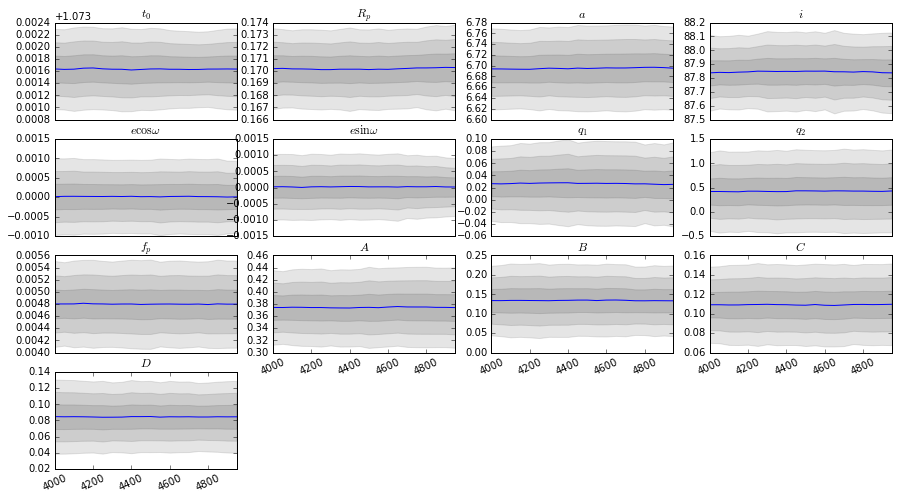

In [70]:
labels = np.array(['$t_0$','$R_p$','$a$','$i$','$e\cos \omega$', '$e \sin \omega$',
                     '$q_1$',r'$q_2$','$f_p$', '$A$', '$B$', '$C$', '$D$'], dtype='object_')

walk_style(13, nwalkers, sampler.chain, 50, 1000, labels)

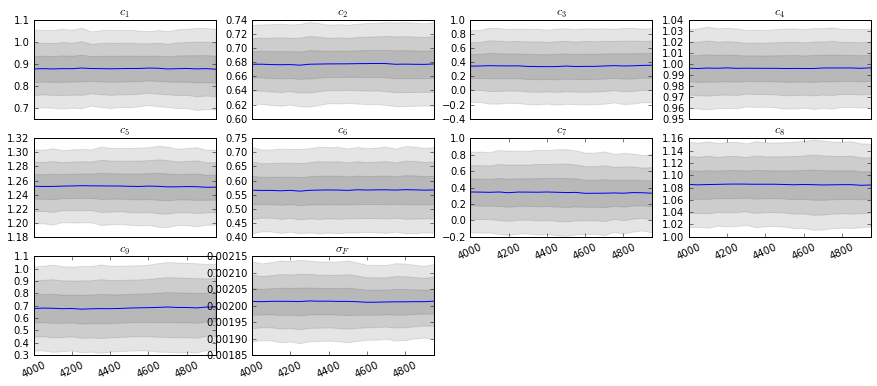

In [71]:
labels = np.array(['$c_1$', '$c_2$', '$c_3$', '$c_4$', '$c_5$',
                   '$c_6$','$c_7$', '$c_8$', '$c_9$', '$\sigma _F$'], 
                  dtype='object_')

walk_style(10, nwalkers, sampler.chain[:,:,13:], 50, 1000, labels)

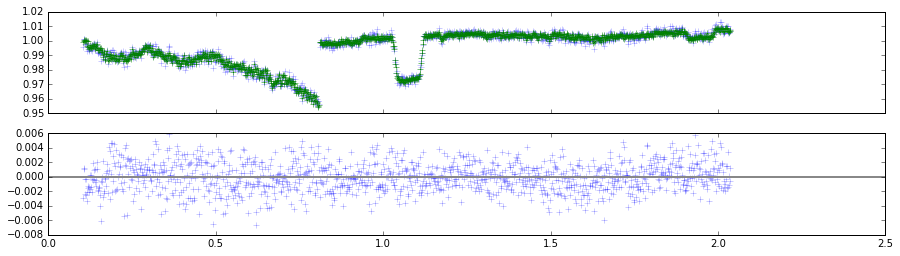

In [72]:
signal_mcmc = signal(time, P1, P2, P3, P4, P5, P6, P7, P8, P9, 
                     c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                     c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0],
                     t0_mcmc[0], rp_mcmc[0], a_mcmc[0], inc_mcmc[0], ecosw_mcmc[0], 
                     esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], fp_mcmc[0], A_mcmc[0], B_mcmc[0], C_mcmc[0], D_mcmc[0])

fig, axes = plt.subplots(ncols = 1, nrows = 2, sharex = True,figsize=(15,4))
axes[0].plot(time, P.sum(axis=1), '+', alpha = 0.4)
axes[0].plot(time, signal_mcmc, '+')
axes[1].plot(time, P.sum(axis=1) - signal_mcmc, '+', alpha = 0.4)
axes[1].axhline(y=0, color="#888888", lw=2)

In [73]:
res_det = detec_model(P1, P2, P3, P4, P5, P6, P7, P8, P9, 
                      c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                      c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0])

res_lightcurve = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], A_mcmc[0], B_mcmc[0], C_mcmc[0], D_mcmc[0])

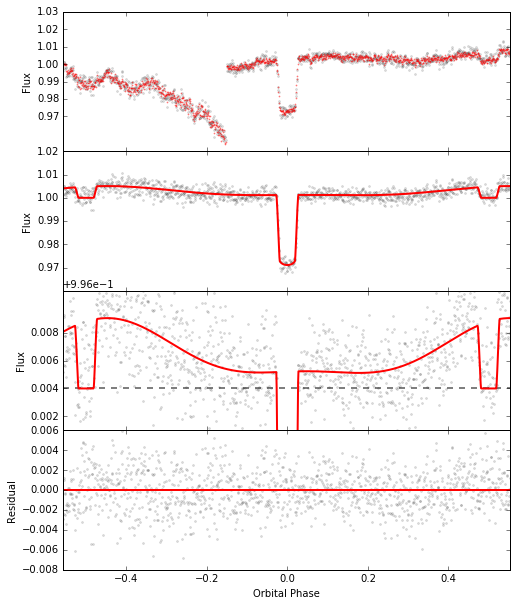

In [74]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 10))
axes[0].set_xlim((np.min(time)-t0_mcmc[0])/per, (np.max(time)-t0_mcmc[0])/per)
axes[0].plot((time-t0_mcmc[0])/per, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[0].plot((time-t0_mcmc[0])/per, res_lightcurve*res_det, '.', color = 'r', markersize = 2.5, alpha = 0.4)
axes[0].set_yticks(np.arange(0.97, 1.03, 0.01))
axes[0].set_ylabel('Flux')

axes[1].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[1].plot((time-t0_mcmc[0])/per, res_lightcurve, color = 'r', linewidth=2)
axes[1].set_yticks(np.arange(0.97, 1.02, 0.01))
axes[1].set_ylabel('Flux')
#axes[1].set_ylim(0.995, 1.005)
#axes[1].axhline(y=1, color='b')
#axes[1].axhline(y=1+0.004231819514801176, color='b')
axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
axes[2].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[2].plot((time-t0_mcmc[0])/per, res_lightcurve, color = 'r', linewidth=2)
axes[2].set_yticks(np.arange(0.996, 1.005, 0.002))
axes[2].set_ylabel('Flux')
axes[2].set_ylim(0.997, 1.007)

axes[3].plot((time-t0_mcmc[0])/per, flux/res_det - res_lightcurve, 'k.', markersize = 4, alpha = 0.15)
axes[3].axhline(y=0, color='r', linewidth = 2)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Orbital Phase')

fig.subplots_adjust(hspace=0)
plotname = foldername + '/MCMC_PLD_var2_2.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [75]:
def chi2(data, fit, err):
    N     = len(data)
    denom = (data - fit)**2
    numer = err**2
    chi2  = np.sum(denom/numer)
    return chi2

def loglikelihood(data, fit, err):
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((data-fit)**2*inv_sigma2 - np.log(inv_sigma2)))

def BIC(logL, Npar, Ndat):
    E = logL - (Npar/2)*np.log(Ndat)
    return E

ferr_fit = np.ones(len(flux))* sigF_mcmc[0]

data = (flux/res_det)
fit  = res_lightcurve
chisB = chi2(data, fit, ferr_fit)


print(chisB)
logLB = loglikelihood(data, fit, ferr_fit
                     )
print('Likelihood: ',logLB)
EB = BIC(logLB, ndim, len(data))
print('Evidence: ', EB)

1291.61750688
Likelihood:  7350.23698795
Evidence:  7267.88726003


In [76]:
from astropy.stats import sigma_clip

def get_data_full(folderdata):
    path = folderdata + '/ch2_datacube_full_AORs579.dat'
    P    = np.loadtxt(path, usecols=(0,1,2,3,4,5,6,7,8), skiprows=1)
    time = np.loadtxt(path, usecols=[9], skiprows=1)
    P    = P/np.nanmedian(P.sum(axis=1))
    return P, time
    
'''Full Data'''
P_full, time_full = get_data_full(foldername)
time_full = time_full - start

'''Order in chronological order'''
index = np.argsort(time_full)
P_full = P_full[index]
time_full = time_full[index]

'''crop the first 2.5 hours'''
index = np.argsort(time_full)
P_full = P_full[70*64:]
time_full = time_full[70*64:]

'''Sigma clip per data cube'''
P_clean = np.ma.empty((1288*64, 9))

for i in range(1288):
    beg = int(i*64)
    end = int((i+1)*64)
    P_clean[beg:end, :] = np.ma.copy(sigma_clip(P_full[beg:end], axis = 0))
    #flux_clean  = np.ma.append(flux_clean, sigma_clip(np.ma.sum(P_full[beg:end,:], axis = 1)))

''' mask all frame'''
masktmp = np.sum(P_clean.mask, axis=1)
mask = np.empty((1288*64, 9))
mask[:,0] = mask[:,1] = mask[:,2] = mask[:,3] = mask[:,4] = mask[:,5] = mask[:,6] = mask[:,7] = mask[:,8] = masktmp
P_clean2 = np.ma.masked_array(np.array(P_clean), mask = mask)

flux_clean = np.ma.sum(P_clean2, axis = 1)
Pnorm_clean = P_clean2/flux_clean[:,None]

'''Pnorms'''

P1_clean = Pnorm_clean[:,0]
P2_clean = Pnorm_clean[:,1]
P3_clean = Pnorm_clean[:,2]
P4_clean = Pnorm_clean[:,3]
P5_clean = Pnorm_clean[:,4]
P6_clean = Pnorm_clean[:,5]
P7_clean = Pnorm_clean[:,6]
P8_clean = Pnorm_clean[:,7]
P9_clean = Pnorm_clean[:,8]

det_full = detec_model(P1_clean, P2_clean, P3_clean, P4_clean, P5_clean, 
                       P6_clean, P7_clean, P8_clean, P9_clean, c1_mcmc[0], 
                       c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                       c6_mcmc[0], c7_mcmc[0] ,c8_mcmc[0], c9_mcmc[0])

lc_full  = ideal_lightcurve2(time_full, t0_mcmc[0], rp_mcmc[0], a_mcmc[0],
                             inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], 
                             q2_mcmc[0], fp_mcmc[0], A_mcmc[0], B_mcmc[0], C_mcmc[0], D_mcmc[0])

model_full = det_full*lc_full

'''Get Fitted Uncertainty'''
ferr_clean = np.ones(len(flux_clean))*sigF_mcmc[0]*np.sqrt(64)

N = len(model_full)-np.sum((model_full).mask)

chis = chi2(flux_clean, model_full, ferr_clean)
print('$\chi ^2 = $',chis)
logL = loglikelihood(flux_clean, lc_full*det_full, ferr_clean)
print('$\ln(L)=$',logL)
E = BIC(logL, ndim, N)
print('$E =$', E)

print('N', N)

$\chi ^2 = $ 30413.5556868
$\ln(L)=$ 317233.610258
$E =$ 317103.703258
N 80520


# Corner Plots

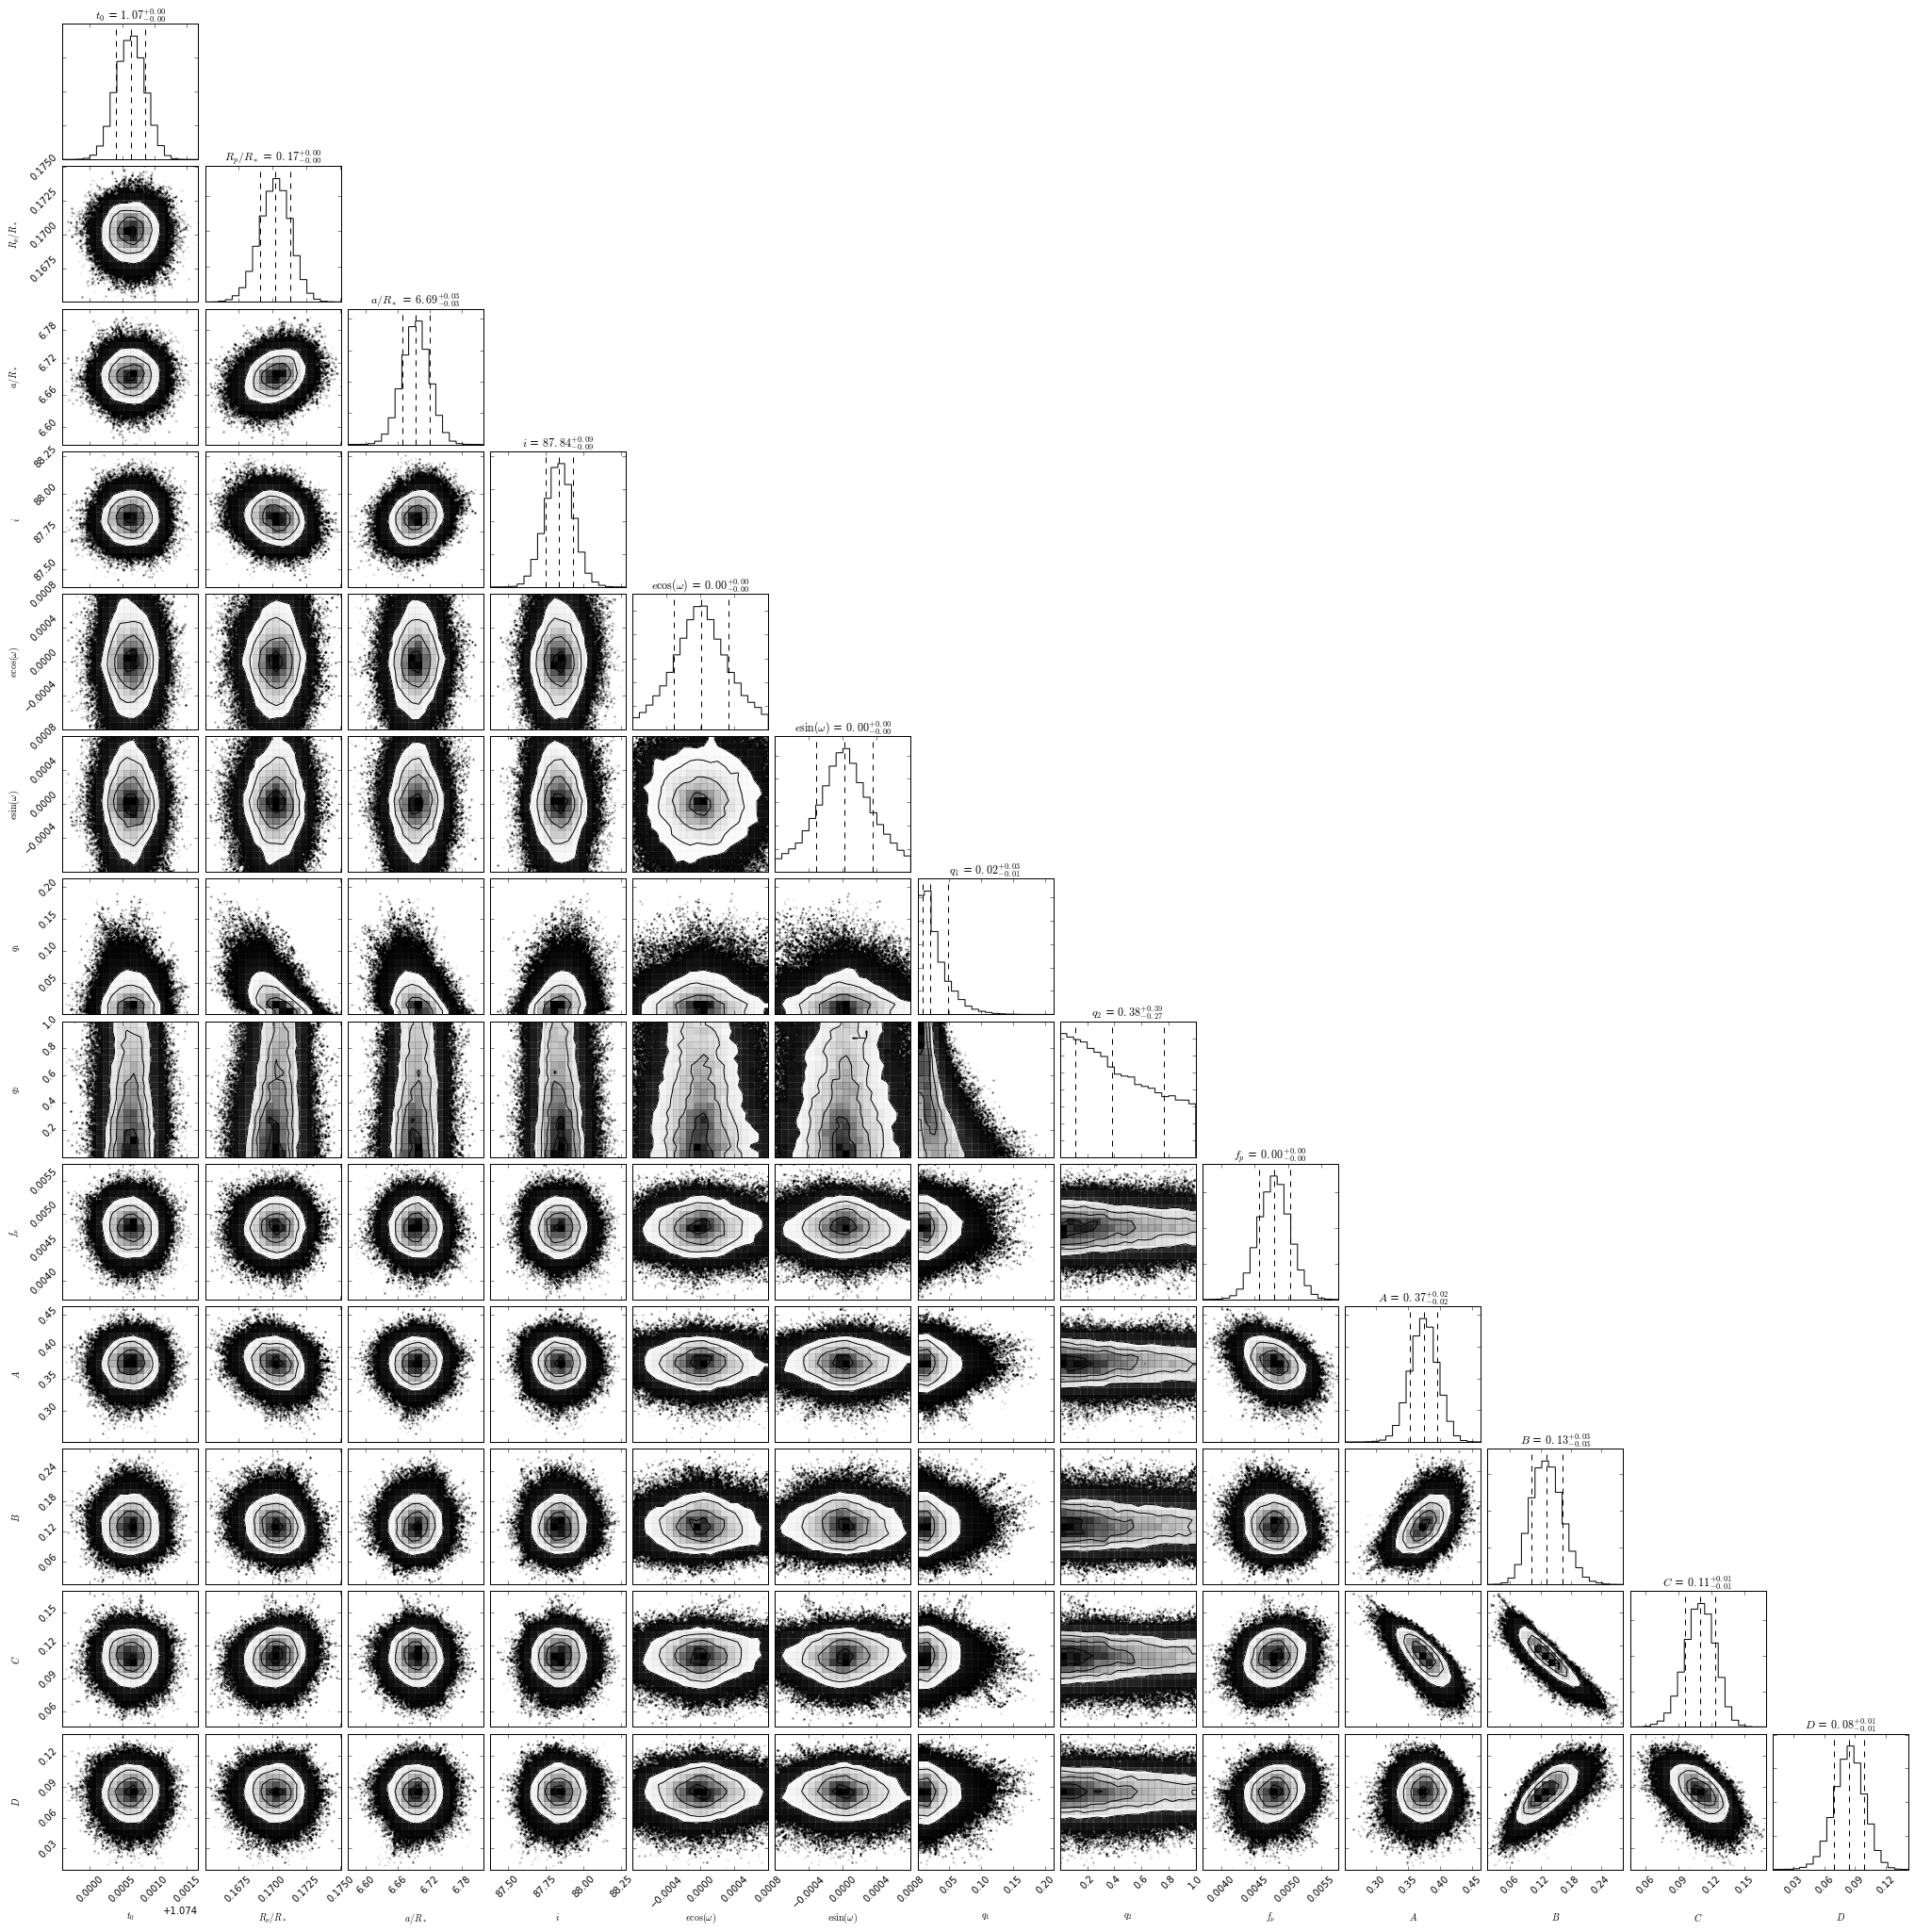

In [78]:
fig = corner.corner(samples[:,0:13], labels=["$t_0$","$R_p/R_*$", "$a/R_*$", "$i$",
                                             "$e \cos(\omega)$", "$e \sin(\omega)$", "$q_1$", "$q_2$", '$f_p$', '$A$', '$B$', '$C$', '$D$'], 
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plotname = foldername + '/MCMC_PLD_var2_3.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [79]:
e_chain = np.sqrt(samples[:,4]**2 + samples[:,5]**2)
w_chain = np.arctan(samples[:,5]/samples[:,4])
u1_chain = 2*np.sqrt(samples[:,6]**2)*samples[:,7]
u2_chain = np.sqrt(samples[:,6]**2)*(1-2*samples[:,7])
binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)

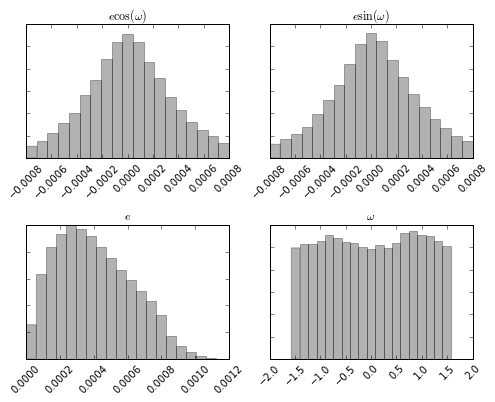

In [80]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,4], bins=np.linspace(np.min(samples[:,4]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,5], bins=np.linspace(np.min(samples[:,5]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
axes[1,0].set_title('$e$', fontsize=12)
axes[1,1].set_title('$\omega$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + '/MCMC_PLD_var2_5.pdf'
fig.savefig(plotname, bbox_inches='tight')

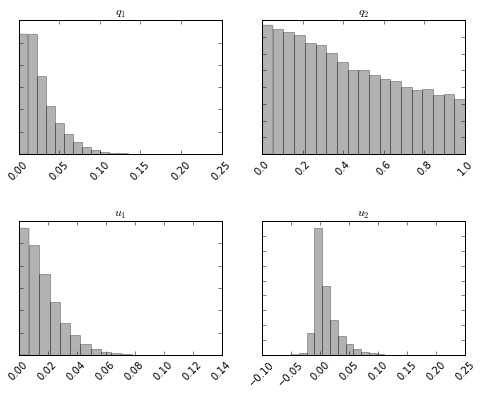

In [81]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,6], bins=np.linspace(np.min(samples[:,6]), np.max(samples[:,6]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,7], bins=np.linspace(np.min(samples[:,7]), np.max(samples[:,7]), 20), color='k', alpha=0.3)
axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$q_1$', fontsize=12)
axes[0,1].set_title('$q_2$', fontsize=12)
axes[1,0].set_title('$u_1$', fontsize=12)
axes[1,1].set_title('$u_2$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + '/MCMC_PLD_var2_6.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [82]:
def triangle_colors(data1, data2, data3, data4, bins, res, label):
    fig = plt.figure(figsize = (8,8))
    gs  = gridspec.GridSpec(len(data1)-1,len(data1)-1)
    i = 0
    for k in range(np.sum(np.arange(len(data1)))):
        j= k - np.sum(np.arange(i+1))
        ax = fig.add_subplot(gs[i,j])
        ax.plot(data1[j], data1[i+1],'k.', markersize = 0.5)
        l1 = ax.plot(data2[j], data2[i+1],'.', color = '#66ccff', markersize = 0.7, label='$1^{st}$ secondary eclipse')
        l2 = ax.plot(data3[j], data3[i+1],'.', color = '#ff9933', markersize = 0.7, label='transit')
        l3 = ax.plot(data4[j], data4[i+1],'.', color = '#0066ff', markersize = 0.7, label='$2^{nd}$ secondary eclipse')
        if (j == 0):
            plt.setp(ax.get_yticklabels(), rotation = 45)
            ax.yaxis.set_major_locator(MaxNLocator(5, prune = 'both'))
            ax.set_ylabel(label[i+1])
        else:
            
            plt.setp(ax.get_yticklabels(), visible=False)
        if (i == len(data1)-2):
            plt.setp(ax.get_xticklabels(), rotation = 45)
            ax.plot(bins[j], res[j], '.', color='#ff5050', markersize = 3)
            ax.xaxis.set_major_locator(MaxNLocator(5, prune = 'both'))
            ax.set_xlabel(label[j])
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
        if(i == j):
            i += 1
    handles = [l1,l2,l3]
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    #fig.legend(handles, ['$1^{st}$ secondary eclipse', 'transit', '$2^{nd}$ secondary eclipse'],bbox_to_anchor = [0.5, -0.05], loc = 'upper center')
    plotname = foldername + '/MCMC_PLD_var2_4.pdf'
    fig.savefig(plotname, bbox_inches='tight')
    #fig.colorbar()

In [83]:
test = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], 0, 0)
index = np.where(test != np.max(test))
ind_ecl1 = np.array([34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97])
ind_ecl2 = np.array([614,  615,
        616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,
        627,  628,  629,  630,  631,  632,  633,  634,  635,  636,  637,
        638,  639,  640,  641,  642,  643,  644,  645,  646,  647,  648,
        649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
        660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
        671,  672,  673,  674,  675,  676,  677])
ind_tra = np.array([1195, 1196, 1197, 1198,
       1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209,
       1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220,
       1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231,
       1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242,
       1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253,
       1254, 1255, 1256, 1257])

ind_trim = ind = np.where(time<np.min(time)+2.5/24.0)

TypeError: ideal_lightcurve2() missing 2 required positional arguments: 'C' and 'D'

In [ ]:
def non_uni_binning(X, Y, bin_nb=50):
    newY = np.empty(bin_nb)
    newX = np.empty(bin_nb)
    bins = np.linspace(np.min(X), np.max(X), bin_nb)
    ind  = np.digitize(X, bins)
    for i in range(bin_nb):
        index = np.where(ind == i+1)
        newX[i] = np.mean(X[index])
        newY[i] = np.mean(Y[index])
    return newX, newY

def binning_data(data, size):
    data = np.ma.masked_invalid(data) 
    reshaped_data   = data.reshape((len(data)/size, size))
    binned_data     = np.ma.median(reshaped_data, axis=1)
    binned_data_std = np.std(reshaped_data, axis=1)
    return binned_data

In [ ]:
residual = flux/res_det - res_lightcurve
bin_x, res_x = non_uni_binning(xdata, residual)
bin_y, res_y = non_uni_binning(ydata, residual)
bin_sx, res_sx = non_uni_binning(psfxw, residual)
bin_sy, res_sy = non_uni_binning(psfyw, residual)
bin_f, res_f = non_uni_binning(flux, residual)

res_bin = [res_x, res_y, res_sx, res_sy, res_f]
bins    = [bin_x, bin_y, bin_sx, bin_sy, bin_f]

bin_x2, res_x2 = binning_data(xdata[:1350], 28), binning_data(residual[:1350],28)
bin_y2, res_y2 = binning_data(ydata[:1350], 28), binning_data(residual[:1350],28)
bin_sx2, res_sx2 = binning_data(psfxw[:1350], 28), binning_data(residual[:1350],28)
bin_sy2, res_sy2 = binning_data(psfyw[:1350],28), binning_data(residual[:1350],28)
bin_f2, res_f2 = binning_data(flux[:1350], 28), binning_data(residual[:1350],28)

res_bin2 = [res_x2, res_y2, res_sx2, res_sy2, res_f2]
bins2    = [bin_x2, bin_y2, bin_sx2, bin_sy2, bin_f2]

In [ ]:
data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecl1], ydata[ind_ecl1], psfxw[ind_ecl1], psfyw[ind_ecl1], flux[ind_ecl1], residual[ind_ecl1]]
data3 = [xdata[ind_tra], ydata[ind_tra], psfxw[ind_tra], psfyw[ind_tra], flux[ind_tra], residual[ind_tra]]
data4 = [xdata[ind_ecl2], ydata[ind_ecl2], psfxw[ind_ecl2], psfyw[ind_ecl2], flux[ind_ecl2], residual[ind_ecl2]]
label = ['$x_0$', '$y_0$', '$\sigma _x$', '$\sigma _y$', '$F$', 'Residual']

triangle_colors(data1, data2, data3, data4, bins2, res_bin2, label)

In [85]:
ResultMCMC_Params = Table()
ResultMCMC_Params['t0'] = [t0_mcmc]
#ResultMCMC_Params['per'] =[ per_mcmc]
ResultMCMC_Params['rp'] = [rp_mcmc]
ResultMCMC_Params['a'] = [a_mcmc] 
ResultMCMC_Params['inc'] = [inc_mcmc]
ResultMCMC_Params['ecosw'] = [ecosw_mcmc]
ResultMCMC_Params['esinw'] = [esinw_mcmc]
ResultMCMC_Params['q1'] = [q1_mcmc]
ResultMCMC_Params['q2'] = [q2_mcmc]
ResultMCMC_Params['fp'] = [fp_mcmc]

ResultMCMC_Params['A'] = [A_mcmc]
ResultMCMC_Params['B'] = [B_mcmc]
ResultMCMC_Params['C'] = [C_mcmc]
ResultMCMC_Params['D'] = [D_mcmc]

ResultMCMC_Params['c1'] = [c1_mcmc]
ResultMCMC_Params['c2'] = [c2_mcmc]
ResultMCMC_Params['c3'] = [c3_mcmc]
ResultMCMC_Params['c4'] = [c4_mcmc]
ResultMCMC_Params['c5'] = [c5_mcmc]
ResultMCMC_Params['c6'] = [c6_mcmc]
ResultMCMC_Params['c7'] = [c7_mcmc]
ResultMCMC_Params['c8'] = [c8_mcmc]
ResultMCMC_Params['c9'] = [c9_mcmc]

ResultMCMC_Params['sigF'] = [sigF_mcmc]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
ResultMCMC_Params['evidence'] = [E]

pathres = foldername + '/ResultMCMC_PLD_var2_Params.npy'
np.save(pathres, ResultMCMC_Params)

In [78]:
P.shape

(1288, 9)